#Reconstruction and deconstruction of human somitogenesis in vitro

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE195467

Dataset 2: Somitoid & Segmentoid Differentiation (GSE195467)

Source: Extended time-course from iPSCs through segmentation-like structures
Timepoints Used: Day 0 to Day 7
Preprocessing: Sample folders parsed and mapped to biological labels (e.g., “Somitoid 48h”)
Application: Evaluated emergence of CNAs in early somitogenesis trajectory



In [ ]:
# Install packages
!pip install scanpy scipy umap-learn leidenalg scFates
!pip install hmmlearn

In [ ]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import scanpy as sc
import scFates as scf
import numpy as np
import pandas as pd
from anndata import AnnData
from typing import Dict, Tuple
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from scipy.sparse import issparse

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

adata = sc.read("/content/drive/MyDrive/compscfiles/task3finalproject/GSE195467_combined_raw_unlabeled.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 21114 × 36601
    obs: 'source_folder', 'original_batch'
    var: 'gene_symbols', 'feature_types'

In [ ]:
adata



AnnData object with n_obs × n_vars = 21114 × 36601
    obs: 'source_folder', 'original_batch'
    var: 'gene_symbols', 'feature_types'

In [ ]:
import scanpy as sc
import pandas as pd
import re
import os

# Load the dataset
adata = sc.read("/content/drive/MyDrive/compscfiles/task3finalproject/GSE195467_combined_raw_unlabeled.h5ad")

print(f"Dataset shape: {adata.shape}")
print(f"Batch distribution:\n{adata.obs['original_batch'].value_counts()}")

# Add condition/timepoint information for better organization
batch_to_condition = {
    "GSM5837936_sample1_t1": "iPSC",
    "GSM5837937_sample1_t2": "Somitoid_24h",
    "GSM5837938_sample1_t3": "Segmentoid_24h",
    "GSM5837939_sample1_t4": "Segmentoid_48h",
    "GSM5837940_sample2_t1": "Somitoid_48h",
    "GSM5837941_sample2_t2": "Somitoid_66h",
    "GSM5837942_sample2_t3": "Somitoid_98h",
    "GSM5837943_sample3_t1": "Segmentoid_72h",
    "GSM5837944_sample3_t2": "Segmentoid_98h"
}

# Add condition/timepoint as a temporary cell type
adata.obs['cell_type'] = adata.obs['original_batch'].map(batch_to_condition)

# Check if we have gene symbols and ensure gene_name column exists
if 'gene_symbols' in adata.var.columns:
    print(f"Gene symbols already present for {adata.var['gene_symbols'].notna().sum()} genes")
    adata.var['gene_name'] = adata.var['gene_symbols']
else:
    print("No gene symbols found, using var_names as gene_name")
    adata.var['gene_name'] = adata.var_names

# Parse GTF file to get genomic locations
def parse_gtf(gtf_path):
    """Parse a GTF file and extract gene locations."""
    # Load GTF file (skip comment lines)
    gtf = pd.read_csv(
        gtf_path,
        sep="\t",
        comment="#",
        header=None,
        names=[
            "chromosome", "source", "feature", "start", "end",
            "score", "strand", "frame", "attribute"
        ]
    )

    # Keep only 'gene' entries
    genes = gtf[gtf["feature"] == "gene"].copy()

    # Extract gene_name from attribute column
    def extract_attr(attr_string, key):
        match = re.search(f'{key} "([^"]+)"', attr_string)
        return match.group(1) if match else None

    genes["gene_name"] = genes["attribute"].apply(lambda x: extract_attr(x, "gene_name"))
    genes["gene_id"] = genes["attribute"].apply(lambda x: extract_attr(x, "gene_id"))

    # Return only needed columns
    return genes[["gene_name", "gene_id", "chromosome", "start", "end"]].dropna()

# Path to GTF file
gtf_path = "/content/drive/MyDrive/compscfiles/gencode.v47.primary_assembly.annotation.gtf"

# Check if GTF file exists
if not os.path.exists(gtf_path):
    print("GTF file not found. Please download it or provide the correct path.")
else:
    # Parse GTF file
    gene_df = parse_gtf(gtf_path)
    print(f"Parsed {len(gene_df)} genes from GTF file")

    # Remove duplicates from gene_df
    gene_df_unique = gene_df.drop_duplicates(subset="gene_name")
    print(f"Using {len(gene_df_unique)} unique gene names from GTF")

    # Merge genomic locations with adata.var
    # First make sure gene_name is the index of gene_df
    gene_df_unique = gene_df_unique.set_index("gene_name")

    # Add genomic locations to adata.var
    for col in ["chromosome", "start", "end"]:
        adata.var[col] = adata.var["gene_name"].map(gene_df_unique[col])

    # Check how many genes have genomic locations
    with_locations = adata.var.dropna(subset=["chromosome", "start", "end"])
    print(f"Added genomic locations for {len(with_locations)} genes out of {adata.n_vars}")

    # Save the enhanced dataset
    adata.write("/content/drive/MyDrive/compscfiles/task3finalproject/GSE195467_with_genomic_locations.h5ad")
    print("Saved dataset with genomic locations")

    # Create a filtered version with only genes that have genomic locations
    adata_filtered = adata[:, ~adata.var[["chromosome", "start", "end"]].isna().any(axis=1)].copy()

    # Save filtered version
    adata_filtered.write("/content/drive/MyDrive/compscfiles/task3finalproject/GSE195467_filtered_with_genomic_locations.h5ad")
    print(f"Saved filtered dataset with shape: {adata_filtered.shape}")

# Print columns in adata.var to verify
print("\nColumns in adata.var:")
print(adata.var.columns.tolist())

print("\nColumns in adata.obs:")
print(adata.obs.columns.tolist())


Dataset shape: (21114, 36601)
Batch distribution:
original_batch
GSM5837943_sample3_t1    3768
GSM5837944_sample3_t2    3598
GSM5837941_sample2_t2    2755
GSM5837940_sample2_t1    2651
GSM5837942_sample2_t3    2178
GSM5837936_sample1_t1    1779
GSM5837939_sample1_t4    1697
GSM5837937_sample1_t2    1388
GSM5837938_sample1_t3    1300
Name: count, dtype: int64
Gene symbols already present for 36601 genes
Parsed 78932 genes from GTF file
Using 77307 unique gene names from GTF
Added genomic locations for 23251 genes out of 36601
Saved dataset with genomic locations
Saved filtered dataset with shape: (21114, 23251)

Columns in adata.var:
['gene_symbols', 'feature_types', 'gene_name', 'chromosome', 'start', 'end']

Columns in adata.obs:
['source_folder', 'original_batch', 'cell_type']


In [ ]:
adata_filtered.obs

,source_folder,original_batch,cell_type
AAACCCACATACCATG-1-GSM5837936_sample1_t1,GSM5837936_sample1_t1,GSM5837936_sample1_t1,iPSC
AAACGAATCTGCGTCT-1-GSM5837936_sample1_t1,GSM5837936_sample1_t1,GSM5837936_sample1_t1,iPSC
AAACGAATCTTCCCGA-1-GSM5837936_sample1_t1,GSM5837936_sample1_t1,GSM5837936_sample1_t1,iPSC
AAACGCTCATCGTGCG-1-GSM5837936_sample1_t1,GSM5837936_sample1_t1,GSM5837936_sample1_t1,iPSC
AAACGCTCATGGGATG-1-GSM5837936_sample1_t1,GSM5837936_sample1_t1,GSM5837936_sample1_t1,iPSC
...,...,...,...
TTTGTTGAGAAATTCG-1-GSM5837944_sample3_t2,GSM5837944_sample3_t2,GSM5837944_sample3_t2,Segmentoid_98h
TTTGTTGAGCATCCCG-1-GSM5837944_sample3_t2,GSM5837944_sample3_t2,GSM5837944_sample3_t2,Segmentoid_98h
TTTGTTGCAATCACGT-1-GSM5837944_sample3_t2,GSM5837944_sample3_t2,GSM5837944_sample3_t2,Segmentoid_98h
TTTGTTGCATTCACAG-1-GSM5837944_sample3_t2,GSM5837944_sample3_t2,GSM5837944_sample3_t2,Segmentoid_98h


In [ ]:
 def plot_cluster_means_by_genomic_position(adata, layer=None, group_by="cell_type", downsample=100):
    """
    Plots mean expression across genomic positions for each group in `adata`.
    Parameters:
    - adata: AnnData object with `obs[group_by]` defined.
    - layer: Layer name containing count data. If None, uses adata.X.
    - group_by: Column in `adata.obs` to group cells (e.g., "cell_type").
    - downsample: Plot every nth gene to reduce visual clutter.
    """
    gene_indices = np.arange(0, adata.n_vars, downsample)

    # Get chromosome info if available
    chromosomes = adata.var["chromosome"].values[gene_indices] if "chromosome" in adata.var else None

    if chromosomes is not None:
        valid_chroms = [str(i) for i in range(1, 23)] + ['X', 'chrX']
        chrom_mask = np.isin(chromosomes, valid_chroms)
        chrom_changes = np.where((chromosomes[:-1] != chromosomes[1:]) &
                               (chrom_mask[:-1] | chrom_mask[1:]))[0] + 1
        chrom_boundaries = [0] + chrom_changes.tolist() + [len(chromosomes)]
        chrom_midpoints = [(chrom_boundaries[i] + chrom_boundaries[i+1]) // 2
                         for i in range(len(chrom_boundaries)-1)]
        chrom_labels = [chromosomes[i] for i in chrom_boundaries[:-1]]

    # Calculate global Y-axis limits
    all_means = []
    for group in adata.obs[group_by].unique():
        group_mask = adata.obs[group_by] == group
        # Get data from specified layer or use X if layer is None
        if layer is not None:
            group_data = adata[group_mask].layers[layer][:, gene_indices]
        else:
            group_data = adata[group_mask].X[:, gene_indices]

        if issparse(group_data):
            group_data = group_data.toarray()
        all_means.append(np.mean(group_data, axis=0))

    global_ymin = min(np.min(means) for means in all_means)
    global_ymax = max(np.max(means) for means in all_means)
    y_padding = (global_ymax - global_ymin) * 0.1

    # 1. Combined Plot
    plt.figure(figsize=(14, 6))
    for group, means in zip(adata.obs[group_by].unique(), all_means):
        plt.plot(means, label=f"{group}", linewidth=1)

    if chromosomes is not None:
        for x in chrom_boundaries[1:-1]:
            if x < len(chrom_mask) and chrom_mask[x]:
                plt.axvline(x, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        plt.xticks(
            [mp for mp, lbl in zip(chrom_midpoints, chrom_labels) if lbl in valid_chroms],
            [lbl for lbl in chrom_labels if lbl in valid_chroms],
            rotation=90
        )

    plt.ylim(global_ymin - y_padding, global_ymax + y_padding)
    plt.title(f"All Groups (Downsampled {downsample}x)")
    plt.xlabel("Genomic Position")
    plt.ylabel("Mean Counts")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # 2. Individual Group Plots
    for group, means in zip(adata.obs[group_by].unique(), all_means):
        plt.figure(figsize=(14, 4))
        plt.plot(means, color='steelblue', linewidth=1)

        if chromosomes is not None:
            for x in chrom_boundaries[1:-1]:
                if x < len(chrom_mask) and chrom_mask[x]:
                    plt.axvline(x, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
            plt.xticks(
                [mp for mp, lbl in zip(chrom_midpoints, chrom_labels) if lbl in valid_chroms],
                [lbl for lbl in chrom_labels if lbl in valid_chroms],
                rotation=90
            )

        plt.ylim(global_ymin - y_padding, global_ymax + y_padding)
        plt.title(f"Group: {group}\n(Mean Expression, {downsample}x downsampled)")
        plt.xlabel("Genomic Position")
        plt.ylabel("Mean Counts")
        plt.tight_layout()
        plt.show()

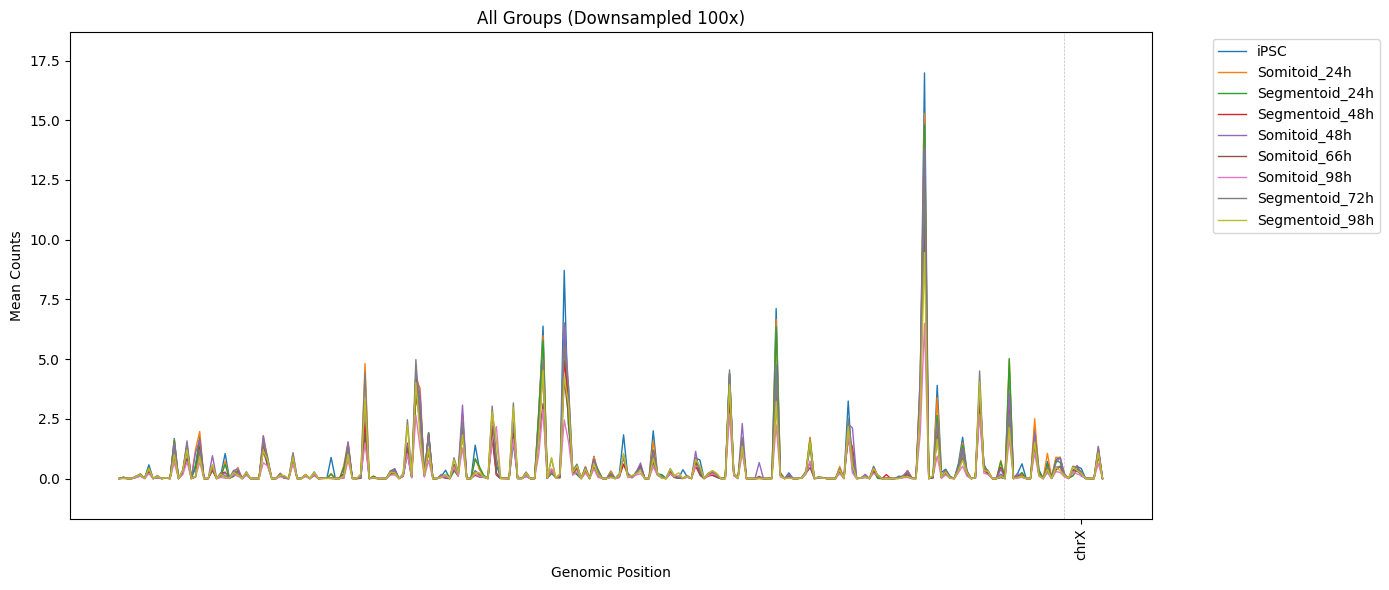

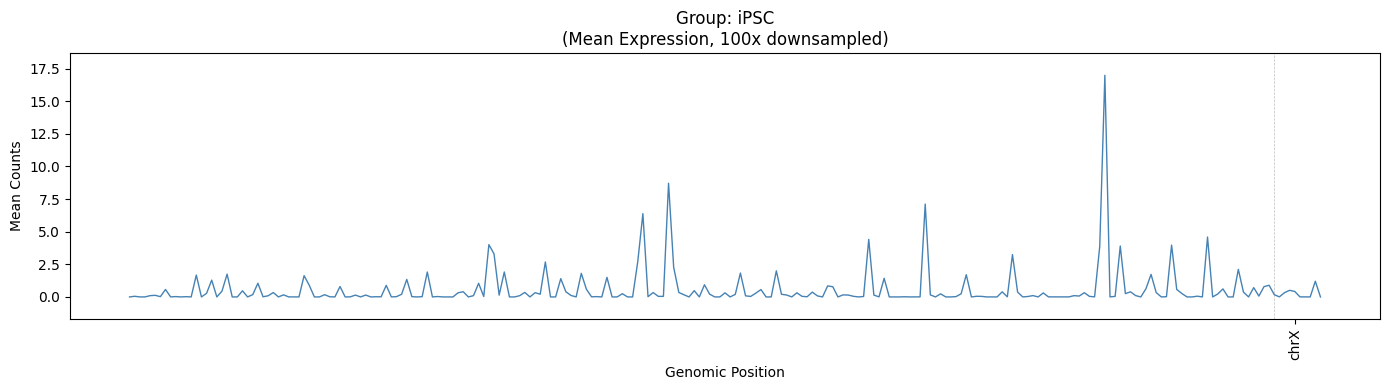

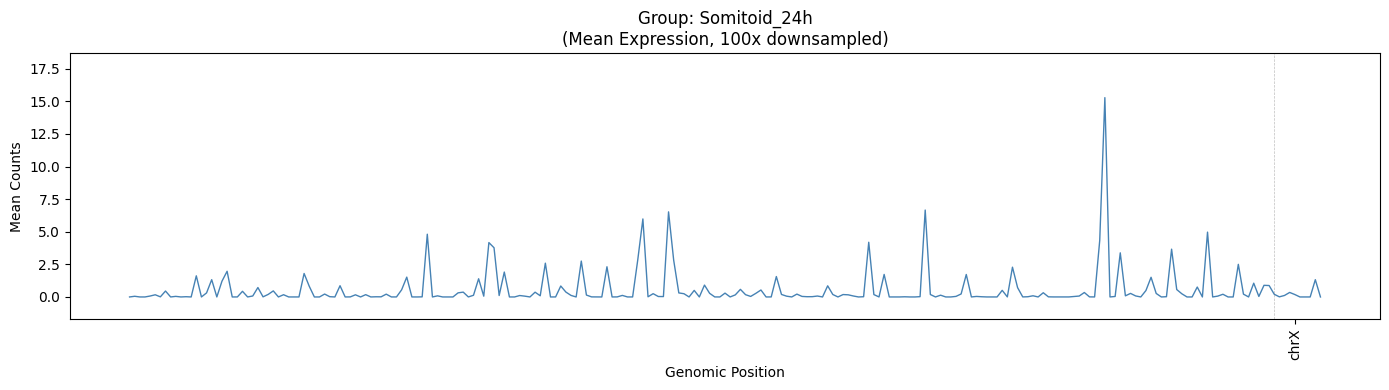

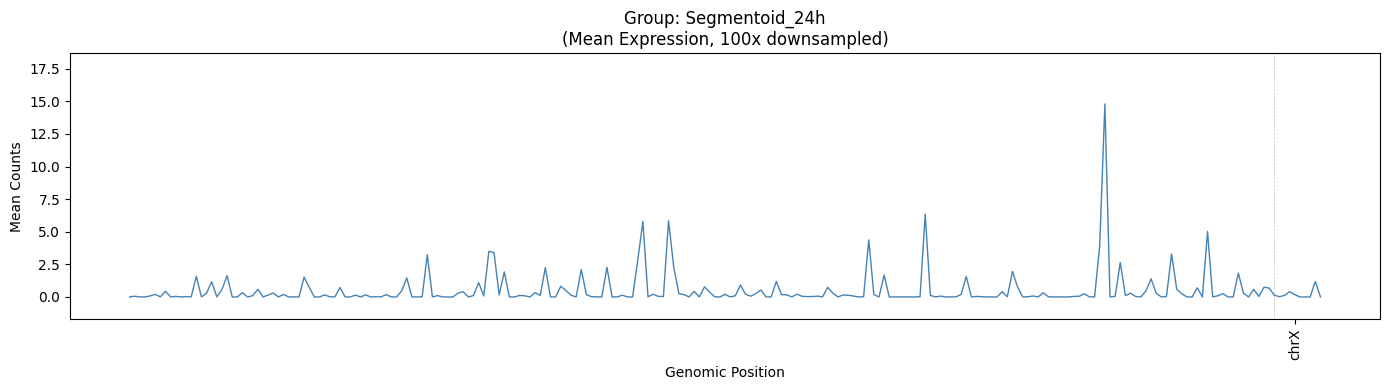

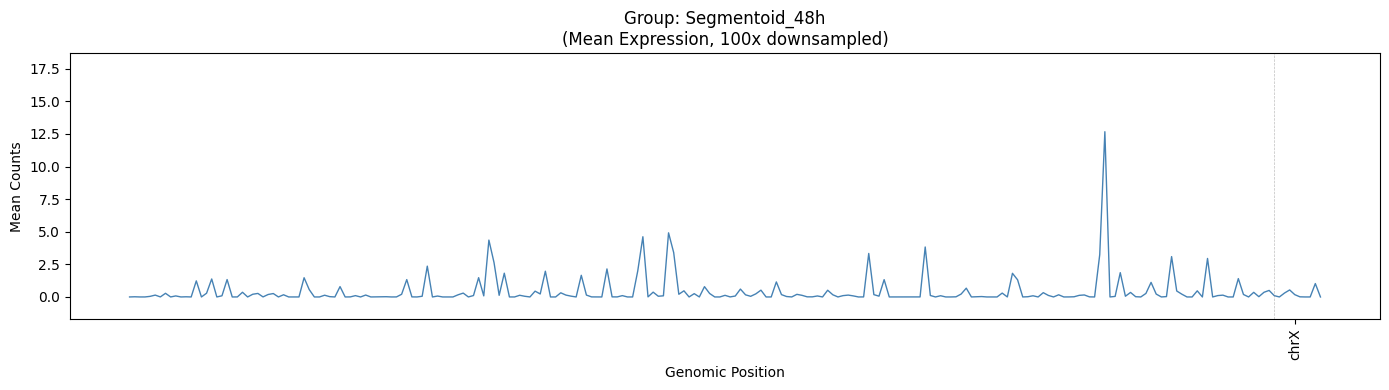

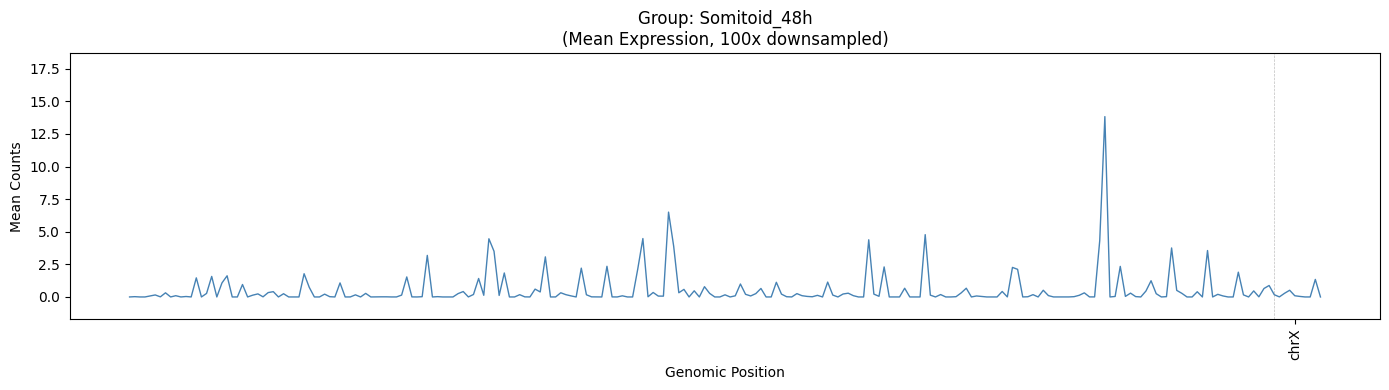

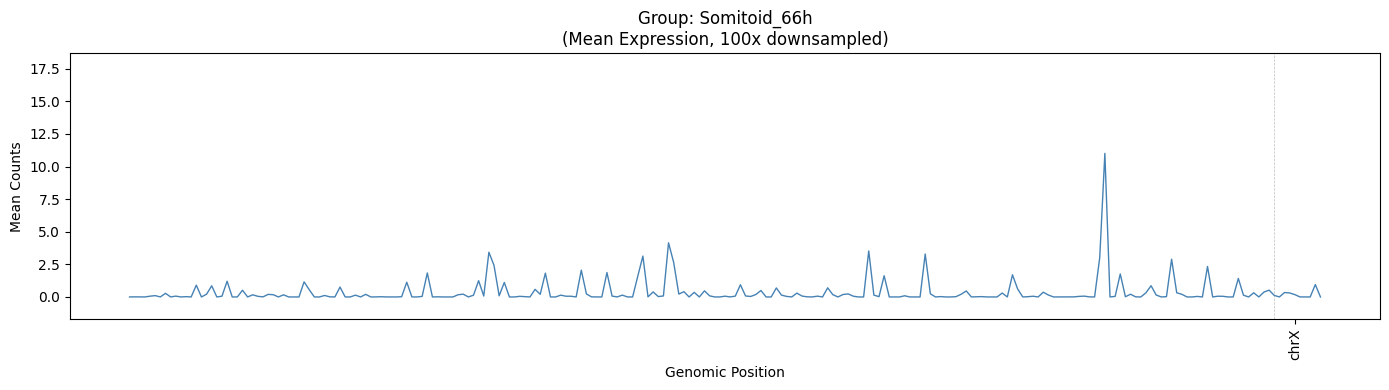

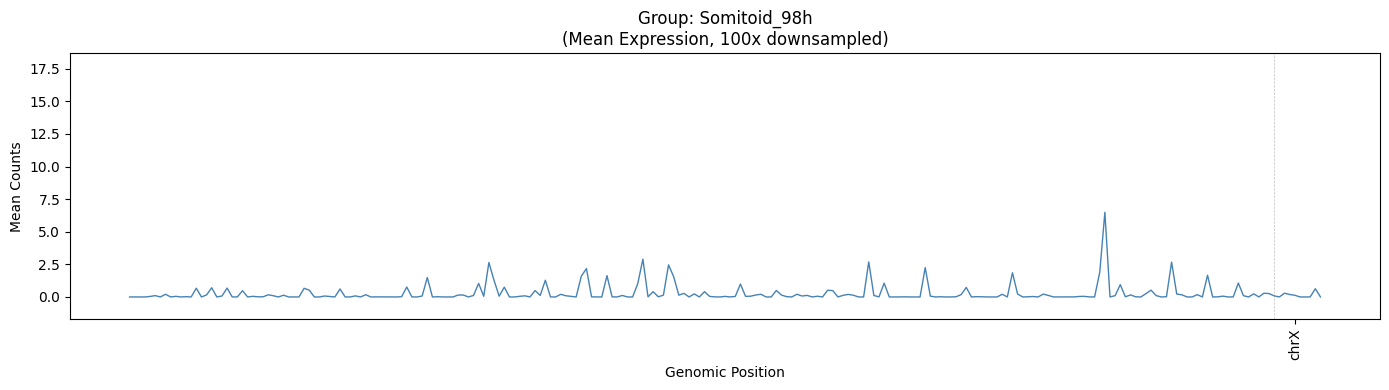

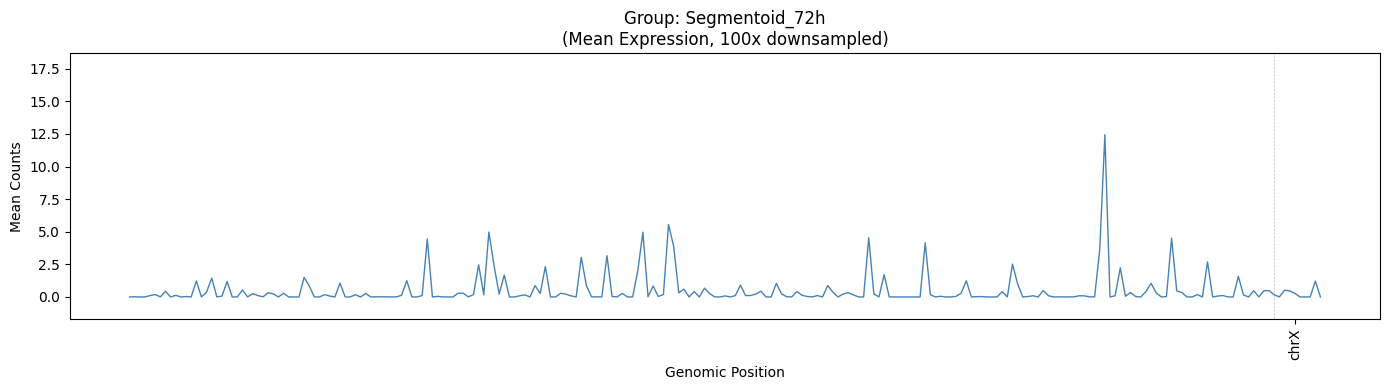

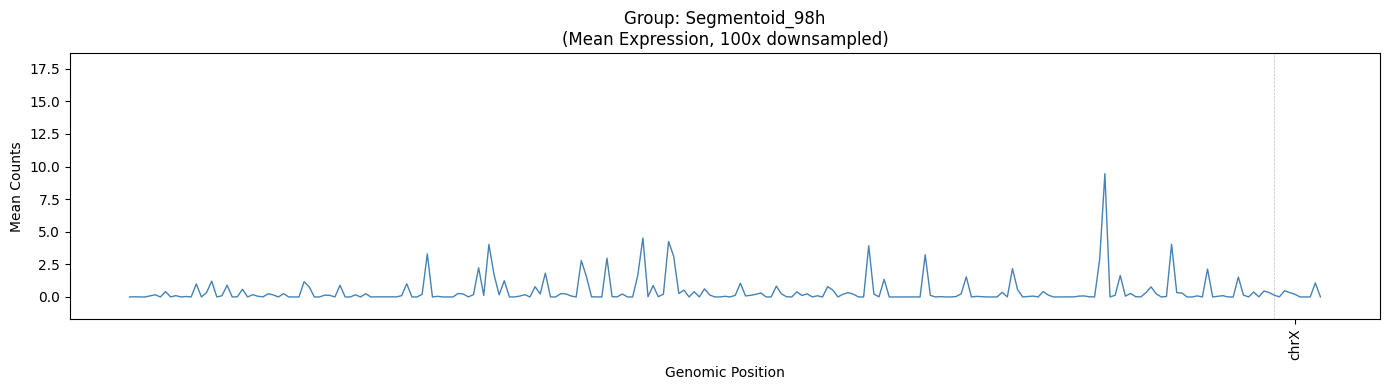

In [ ]:
plot_cluster_means_by_genomic_position(adata_filtered, layer=None, group_by="cell_type", downsample=100)

In [ ]:
def smooth_expression_matrix(matrix, window_size=15):
    """
    Applies a sliding window average across genes.
    """
    smoothed = []
    gene_names = matrix.columns.to_list()

    for i in range(len(gene_names) - window_size + 1):
        window = gene_names[i:i + window_size]
        avg_expr = matrix[window].mean(axis=1)
        smoothed.append(avg_expr.rename(f"{window[0]}_to_{window[-1]}"))

    return pd.concat(smoothed, axis=1)

def compute_smoothed_profiles_minimal(
    adata,
    use_layer=None,
    group_by='cell_type',
    window_size=15,
    ref='iPSC',
    batch_size=200,
    gene_stride=10
):
    """
    Ultra-minimal version of compute_smoothed_profiles with aggressive memory optimization.
    """
    import gc
    import numpy as np
    import pandas as pd

    print(f"Processing {adata.n_obs} cells with minimal memory usage")

    # 1. Get gene order and subset based on stride
    print("Ordering and striding genes...")
    gene_order = adata.var.sort_values(['chromosome', 'start']).index
    if gene_stride > 1:
        gene_order = gene_order[::gene_stride]
        print(f"Using {len(gene_order)} genes after {gene_stride}x striding")

    # 2. Only load selected genes
    adata_small = adata[:, gene_order].copy()
    print(f"Working with {adata_small.shape[0]} cells and {adata_small.shape[1]} genes")

    # 3. Process in tiny batches
    print("Processing cells in small batches...")
    smoothed_chunks = []

    for batch_start in range(0, adata_small.n_obs, batch_size):
        batch_end = min(batch_start + batch_size, adata_small.n_obs)
        print(f"Batch {batch_start//batch_size + 1}/{(adata_small.n_obs-1)//batch_size + 1}...")

        # Get batch cells
        batch_cells = adata_small.obs_names[batch_start:batch_end]

        # Process this tiny batch
        try:
            # Extract expression
            if use_layer:
                batch_data = adata_small[batch_cells].layers[use_layer]
            else:
                batch_data = adata_small[batch_cells].X

            if hasattr(batch_data, "toarray"):
                batch_data = batch_data.toarray()

            # Convert to DataFrame
            batch_df = pd.DataFrame(
                batch_data,
                index=batch_cells,
                columns=adata_small.var_names
            )

            # Smooth the batch
            batch_smoothed = smooth_expression_matrix(batch_df, window_size)
            smoothed_chunks.append(batch_smoothed)

            # Clean up
            del batch_data, batch_df
            gc.collect()

        except Exception as e:
            print(f"Error in batch {batch_start}-{batch_end}: {e}")
            # Try to continue with next batch

    # 4. Combine results
    print("Combining smoothed results...")
    try:
        smoothed_expr = pd.concat(smoothed_chunks)
        del smoothed_chunks
        gc.collect()
    except Exception as e:
        print(f"Error combining batches: {e}")
        return None, None, None, None

    # 5. Calculate global average
    print("Calculating global average...")
    global_avg = smoothed_expr.mean(axis=0)

    # 6. Calculate cell type averages
    print("Calculating cell type averages...")
    celltype_profiles = {}
    cell_types = adata_small.obs[group_by].unique()

    for ct in cell_types:
        print(f"  Processing {ct}...")
        ct_mask = adata_small.obs[group_by] == ct
        ct_cells = adata_small.obs_names[ct_mask]

        # Get just these cells from smoothed data
        ct_smoothed = smoothed_expr.loc[ct_cells]
        celltype_profiles[ct] = ct_smoothed.mean(axis=0)

        # Clean up
        del ct_smoothed
        gc.collect()

    # 7. Get reference average
    print("Getting reference profile...")
    if ref in celltype_profiles:
        ref_avg = celltype_profiles[ref]
    else:
        raise ValueError(f"Reference '{ref}' not found in {group_by}")

    print("Smoothing complete")
    return smoothed_expr, celltype_profiles, global_avg, ref_avg

In [ ]:
# Run the smoothing function
smoothed, celltype_avg, global_avg, cluster_avg = compute_smoothed_profiles_minimal(
    adata_filtered,
    use_layer=None,
    group_by="cell_type",
    ref="iPSC",
    batch_size=200,    # Very small batches
    window_size=15,    # Smaller window
    gene_stride=10     # Only use every 10th gene
)

Processing 21114 cells with minimal memory usage
Ordering and striding genes...
Using 2326 genes after 10x striding
Working with 21114 cells and 2326 genes
Processing cells in small batches...
Batch 1/106...
Batch 2/106...
Batch 3/106...
Batch 4/106...
Batch 5/106...
Batch 6/106...
Batch 7/106...
Batch 8/106...
Batch 9/106...
Batch 10/106...
Batch 11/106...
Batch 12/106...
Batch 13/106...
Batch 14/106...
Batch 15/106...
Batch 16/106...
Batch 17/106...
Batch 18/106...
Batch 19/106...
Batch 20/106...
Batch 21/106...
Batch 22/106...
Batch 23/106...
Batch 24/106...
Batch 25/106...
Batch 26/106...
Batch 27/106...
Batch 28/106...
Batch 29/106...
Batch 30/106...
Batch 31/106...
Batch 32/106...
Batch 33/106...
Batch 34/106...
Batch 35/106...
Batch 36/106...
Batch 37/106...
Batch 38/106...
Batch 39/106...
Batch 40/106...
Batch 41/106...
Batch 42/106...
Batch 43/106...
Batch 44/106...
Batch 45/106...
Batch 46/106...
Batch 47/106...
Batch 48/106...
Batch 49/106...
Batch 50/106...
Batch 51/106...


In [ ]:
def compute_smoothed_profiles_sampled(
    adata,
    use_layer=None,
    group_by='cell_type',
    window_size=25,
    ref='iPSC',
    sample_ratio=0.1,  # Sample only 10% of cells
    gene_stride=5      # Use every 5th gene
):
    """
    Memory-efficient version that samples cells and genes
    """
    import gc
    import numpy as np
    import pandas as pd

    print(f"Processing {adata.n_obs} cells with sampling approach")

    # Step 1: Order genes by position & use striding to reduce memory
    print("Ordering and sampling genes...")
    gene_order = adata.var.sort_values(['chromosome', 'start']).index
    sampled_genes = gene_order[::gene_stride]
    print(f"Using {len(sampled_genes)} of {len(gene_order)} genes (1/{gene_stride})")

    # Step 2: Sample cells from each cell type
    print("Sampling cells...")
    sampled_cells = []

    for ct in adata.obs[group_by].unique():
        ct_cells = adata.obs_names[adata.obs[group_by] == ct]
        # Sample cells based on ratio, but ensure at least 30 cells per type
        n_sample = max(30, int(len(ct_cells) * sample_ratio))
        if len(ct_cells) > n_sample:
            selected = np.random.choice(ct_cells, n_sample, replace=False)
            sampled_cells.extend(selected)
        else:
            sampled_cells.extend(ct_cells)

    print(f"Using {len(sampled_cells)} of {adata.n_obs} cells")

    # Step 3: Create sampled AnnData and order genes
    adata_sampled = adata[sampled_cells, sampled_genes].copy()

    # Step 4: Get expression matrix
    print("Creating expression matrix...")
    if use_layer:
        expr_data = adata_sampled.layers[use_layer]
    else:
        expr_data = adata_sampled.X

    if hasattr(expr_data, "toarray"):
        expr_data = expr_data.toarray()

    expr = pd.DataFrame(
        expr_data,
        index=adata_sampled.obs_names,
        columns=adata_sampled.var_names
    )

    # Free memory
    del expr_data
    gc.collect()

    # Step 5: Smooth expression
    print(f"Smoothing with window size {window_size}...")
    smoothed_expr = smooth_expression_matrix(expr, window_size)

    # Free memory
    del expr
    gc.collect()

    # Step 6: Calculate global average
    print("Calculating global average...")
    global_avg = smoothed_expr.mean(axis=0)

    # Step 7: Calculate per-cell-type averages
    print("Calculating per-cell-type averages...")
    celltypes = adata_sampled.obs[group_by]
    celltype_profiles = {
        ct: smoothed_expr.loc[celltypes == ct].mean(axis=0)
        for ct in celltypes.unique()
    }

    # Step 8: Get reference average
    print("Getting reference average...")
    if ref in celltype_profiles:
        ref_avg = celltype_profiles[ref]
    else:
        raise ValueError(f"Reference cell type '{ref}' not found in adata.obs['{group_by}'].")

    print("Processing complete!")
    return smoothed_expr, celltype_profiles, global_avg, ref_avg

In [ ]:
# Use the memory-efficient version with sampling
smoothed, celltype_avg, global_avg, cluster_avg = compute_smoothed_profiles_sampled(
    adata_filtered,
    use_layer=None,
    group_by="cell_type",
    ref="iPSC",
    window_size=25,
    sample_ratio=0.1,  # Use 10% of cells
    gene_stride=5      # Use every 5th gene
)

Processing 21114 cells with sampling approach
Ordering and sampling genes...
Using 4651 of 23251 genes (1/5)
Sampling cells...
Using 2106 of 21114 cells
Creating expression matrix...
Smoothing with window size 25...
Calculating global average...
Calculating per-cell-type averages...
Getting reference average...
Processing complete!


In [ ]:
def compute_zscores_for_sampled_data(
    smoothed,
    celltype_avg,
    global_avg,
    cluster_avg,
    adata,
    group_by='cell_type',
    batch_size=500,  # Process in smaller batches
    min_cells_ratio=0.05  # Adaptive threshold based on cell count
):
    """
    Optimized z-score calculation and filtering for sampled data
    """
    print(f"Computing z-scores for {len(smoothed)} sampled cells...")

    # Get dimensions
    sampled_cells = smoothed.index
    genes = smoothed.columns
    n_sampled, n_genes = smoothed.shape

    # Convert the minimum cells threshold to a ratio of sampled cells
    min_cells = max(20, int(n_sampled * min_cells_ratio))
    print(f"Using min_cells threshold of {min_cells} ({min_cells_ratio*100:.1f}% of sampled cells)")

    # Process in batches to reduce memory usage
    delta_global_z_filtered = None
    delta_celltype_z_filtered = None
    delta_cluster_z_filtered = None

    # Count significant genes for filtering
    sig_global_counts = np.zeros(n_genes)
    sig_celltype_counts = np.zeros(n_genes)
    sig_cluster_counts = np.zeros(n_genes)

    print(f"Processing in batches of {batch_size} cells...")
    for batch_start in range(0, n_sampled, batch_size):
        batch_end = min(batch_start + batch_size, n_sampled)
        print(f"Batch {batch_start//batch_size + 1}/{(n_sampled-1)//batch_size + 1}...")

        # Get cells for this batch
        batch_cells = sampled_cells[batch_start:batch_end]

        # Get data for this batch
        batch_data = smoothed.loc[batch_cells].values

        # Get cell types for batch cells
        batch_groups = adata.obs.loc[batch_cells, group_by].values

        # Compute deltas for this batch
        delta_global = batch_data - global_avg.values
        delta_cluster = batch_data - cluster_avg.values

        # Compute deltas for celltype (need to align by cell type)
        delta_celltype = np.zeros_like(batch_data)
        for i, cell_type in enumerate(batch_groups):
            if cell_type in celltype_avg:
                delta_celltype[i] = batch_data[i] - celltype_avg[cell_type].values

        # Z-score normalize
        def zscore_rowwise(matrix):
            mean = np.nanmean(matrix, axis=1, keepdims=True)
            std = np.nanstd(matrix, axis=1, keepdims=True)
            std[std == 0] = 1.0  # Prevent division by zero
            return (matrix - mean) / std

        # Calculate z-scores for this batch
        delta_global_z = zscore_rowwise(delta_global)
        delta_celltype_z = zscore_rowwise(delta_celltype)
        delta_cluster_z = zscore_rowwise(delta_cluster)

        # Count significant genes across all batches
        upper_thresh = 1.5
        lower_thresh = -1.5

        sig_global_counts += np.sum((delta_global_z > upper_thresh) | (delta_global_z < lower_thresh), axis=0)
        sig_celltype_counts += np.sum((delta_celltype_z > upper_thresh) | (delta_celltype_z < lower_thresh), axis=0)
        sig_cluster_counts += np.sum((delta_cluster_z > upper_thresh) | (delta_cluster_z < lower_thresh), axis=0)

        # Free memory
        import gc
        del batch_data, delta_global, delta_celltype, delta_cluster
        gc.collect()

    # Find significant genes based on counts
    global_keep = sig_global_counts >= min_cells
    celltype_keep = sig_celltype_counts >= min_cells
    cluster_keep = sig_cluster_counts >= min_cells

    print(f"Found {np.sum(global_keep)} significant genes in global z-scores")
    print(f"Found {np.sum(celltype_keep)} significant genes in cell-type z-scores")
    print(f"Found {np.sum(cluster_keep)} significant genes in reference cluster z-scores")

    # Create mapping from smoothed genes to adata genes
    gene_indices = {}
    for i, gene in enumerate(genes):
        if gene in adata.var_names:
            gene_idx = np.where(adata.var_names == gene)[0]
            if len(gene_idx) > 0:
                gene_indices[i] = gene_idx[0]

    # Store gene lists
    global_genes = [genes[i] for i in range(n_genes) if global_keep[i]]
    celltype_genes = [genes[i] for i in range(n_genes) if celltype_keep[i]]
    cluster_genes = [genes[i] for i in range(n_genes) if cluster_keep[i]]

    adata.uns['filtered_global_z_genes'] = global_genes
    adata.uns['filtered_celltype_z_genes'] = celltype_genes
    adata.uns['filtered_cluster_z_genes'] = cluster_genes

    print("Z-score calculation complete!")
    return adata, global_genes, celltype_genes, cluster_genes

In [ ]:
def detect_cnvs_with_hmm_for_sampled(
    adata,
    smoothed,
    sampled_cells,
    significant_genes,
    ref_avg,
    output_prefix="hmm_cnv",
    n_components=3,
    n_iter=50,
    chunk_size=50
):
    """
    Run HMM on sampled cells for only significant genes
    """
    import gc
    from sklearn.preprocessing import StandardScaler
    from hmmlearn import hmm
    import warnings

    print(f"Running HMM on {len(significant_genes)} significant genes...")

    # Create a mapping from gene names to indices in var
    gene_indices = {}
    for gene in significant_genes:
        if gene in adata.var_names:
            gene_idx = np.where(adata.var_names == gene)[0]
            if len(gene_idx) > 0:
                gene_indices[gene] = gene_idx[0]

    print(f"Mapped {len(gene_indices)} genes to indices in adata")

    # Calculate delta from reference for sampled cells
    print("Computing expression deltas...")
    delta_values = {}
    for gene in significant_genes:
        if gene in smoothed.columns and gene in ref_avg.index:
            gene_data = smoothed[gene].values
            gene_ref = ref_avg[gene]
            delta_values[gene] = gene_data - gene_ref

    # Prepare data for HMM
    print("Preparing data for HMM...")
    gene_list = list(delta_values.keys())
    data_matrix = np.array([delta_values[gene] for gene in gene_list]).T

    # Check for valid data
    print(f"Data matrix shape: {data_matrix.shape}")
    if data_matrix.size == 0:
        print("No valid data for HMM")
        return adata

    # Initialize HMM model
    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type="diag",
        n_iter=n_iter,
        random_state=42
    )

    # Process in chunks
    all_states = {}
    all_posteriors = {}
    model_fitted = False

    # Process in chunks
    for chunk_start in range(0, len(gene_list), chunk_size):
        chunk_end = min(chunk_start + chunk_size, len(gene_list))
        chunk_genes = gene_list[chunk_start:chunk_end]

        print(f"Processing chunk {chunk_start//chunk_size + 1}/{(len(gene_list)-1)//chunk_size + 1}...")

        # Extract chunk data
        chunk_data = data_matrix[:, chunk_start:chunk_end]

        # Standardize
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(chunk_data)

            # Handle NaNs
            scaled_data = np.nan_to_num(scaled_data)

        # Fit model if not already fitted
        if not model_fitted:
            try:
                model.fit(scaled_data.T)
                model_fitted = True
                print("Model successfully fitted!")
            except Exception as e:
                print(f"Fitting failed: {e}")
                continue

        # Predict states
        try:
            states = model.predict(scaled_data.T)
            posteriors = model.predict_proba(scaled_data.T)

            # Store results
            for i, gene in enumerate(chunk_genes):
                all_states[gene] = states[i]
                all_posteriors[gene] = posteriors[i]
        except Exception as e:
            print(f"Prediction failed: {e}")

        # Free memory
        del chunk_data, scaled_data
        gc.collect()

    # Store results in adata
    print("Storing HMM results in adata...")
    adata.var[f"{output_prefix}_state"] = -1

    for i in range(n_components):
        adata.var[f"{output_prefix}_prob_state_{i}"] = np.nan

    # Update values for significant genes
    for gene, state in all_states.items():
        if gene in gene_indices:
            idx = gene_indices[gene]
            adata.var.iloc[idx, adata.var.columns.get_loc(f"{output_prefix}_state")] = state

            for i in range(n_components):
                prob_col = f"{output_prefix}_prob_state_{i}"
                adata.var.iloc[idx, adata.var.columns.get_loc(prob_col)] = all_posteriors[gene][i]

    # Count states
    state_counts = {state: sum(s == state for s in all_states.values()) for state in range(n_components)}
    for state, count in state_counts.items():
        print(f"  State {state}: {count} genes ({count/len(all_states)*100:.1f}%)")

    print("HMM processing complete!")
    return adata

In [ ]:
def run_cnv_detection_pipeline(adata, ref_cell_type="iPSC"):
    """
    Complete CNV detection pipeline with memory optimization
    """
    import time
    start_time = time.time()

    print("=== Starting CNV Detection Pipeline ===")
    print(f"Dataset shape: {adata.shape}")
    print(f"Reference cell type: {ref_cell_type}")

    #  z-scores
    print("\n=== Step 2: Computing z-scores ===")
    adata, global_genes, celltype_genes, cluster_genes = compute_zscores_for_sampled_data(
        smoothed,
        celltype_avg,
        global_avg,
        cluster_avg,
        adata,
        group_by="cell_type",
        batch_size=500,
        min_cells_ratio=0.05
    )

    # Run HMM on significant genes
    print("\n=== Step 3: Running HMM on cluster z-scores ===")
    adata = detect_cnvs_with_hmm_for_sampled(
        adata,
        smoothed,
        smoothed.index,
        cluster_genes,  # Use cluster z-scores for CNV detection
        cluster_avg,
        output_prefix="hmm_cnv",
        n_components=3,
        n_iter=50,
        chunk_size=50
    )


In [ ]:
# Run the optimized CNV detection pipeline
adata_with_cnvs = run_cnv_detection_pipeline(
    adata_filtered,
    ref_cell_type="iPSC"  # Using iPSC as reference
)

=== Starting CNV Detection Pipeline ===
Dataset shape: (21114, 23251)
Reference cell type: iPSC

=== Step 2: Computing z-scores ===
Computing z-scores for 2106 sampled cells...
Using min_cells threshold of 105 (5.0% of sampled cells)
Processing in batches of 500 cells...
Batch 1/5...
Batch 2/5...
Batch 3/5...
Batch 4/5...
Batch 5/5...
Found 1066 significant genes in global z-scores
Found 1005 significant genes in cell-type z-scores
Found 943 significant genes in reference cluster z-scores
Z-score calculation complete!

=== Step 3: Running HMM on cluster z-scores ===
Running HMM on 943 significant genes...
Mapped 0 genes to indices in adata
Computing expression deltas...
Preparing data for HMM...
Data matrix shape: (2106, 943)
Processing chunk 1/19...
Model successfully fitted!
Processing chunk 2/19...
Processing chunk 3/19...
Processing chunk 4/19...
Processing chunk 5/19...
Processing chunk 6/19...
Processing chunk 7/19...
Processing chunk 8/19...
Processing chunk 9/19...
Processing c

In [ ]:
def show_cnv_summary(adata, hmm_state_column="hmm_cnv_state"):
    """
    Simple function to display CNV regions from HMM states
    """
    import pandas as pd
    import numpy as np

    # Check if the HMM state column exists
    if hmm_state_column not in adata.var.columns:
        print(f"Error: {hmm_state_column} column not found in adata.var")
        return None

    # Create a simple interpretation of states
    state_mapping = {
        0: "Deletion",
        1: "Neutral",
        2: "Amplification"
    }

    # Get genes with valid states
    valid_mask = adata.var[hmm_state_column] >= 0
    valid_genes = adata.var[valid_mask].copy()

    if len(valid_genes) == 0:
        print("No genes with valid states found")
        return None

    # Add CNV type label
    valid_genes['cnv_type'] = valid_genes[hmm_state_column].map(state_mapping)

    # Count states
    state_counts = valid_genes[hmm_state_column].value_counts().sort_index()
    print("State distribution:")
    for state, count in state_counts.items():
        cnv_type = state_mapping.get(state, "Unknown")
        percent = count / len(valid_genes) * 100
        print(f"  State {state} ({cnv_type}): {count} genes ({percent:.1f}%)")

    # Group genes by chromosome and CNV type
    chrom_summary = valid_genes.groupby(['chromosome', 'cnv_type']).size().unstack(fill_value=0)
    print("\nChromosome summary:")
    print(chrom_summary)

    # Create a simple list of CNV regions
    print("\nFinding CNV regions...")
    regions = []

    for cnv_state in [0, 2]:  # Only look at deletion and amplification
        cnv_type = state_mapping[cnv_state]
        state_genes = valid_genes[valid_genes[hmm_state_column] == cnv_state]

        # Process each chromosome
        for chrom in state_genes['chromosome'].unique():
            chrom_genes = state_genes[state_genes['chromosome'] == chrom].sort_values('start')

            if len(chrom_genes) == 0:
                continue

            # Find contiguous regions
            current_region = None
            max_gap = 1000000  # 1Mb maximum gap

            for _, gene in chrom_genes.iterrows():
                if current_region is None:
                    # Start new region
                    current_region = {
                        'chromosome': chrom,
                        'start': gene['start'],
                        'end': gene['end'],
                        'gene_count': 1,
                        'cnv_type': cnv_type
                    }
                elif gene['start'] - current_region['end'] <= max_gap:
                    # Extend region
                    current_region['end'] = gene['end']
                    current_region['gene_count'] += 1
                else:
                    # Save region and start new one
                    regions.append(current_region)
                    current_region = {
                        'chromosome': chrom,
                        'start': gene['start'],
                        'end': gene['end'],
                        'gene_count': 1,
                        'cnv_type': cnv_type
                    }

            # Add final region
            if current_region is not None:
                regions.append(current_region)

    # Convert to DataFrame and display
    if regions:
        regions_df = pd.DataFrame(regions)
        regions_df['size_mb'] = (regions_df['end'] - regions_df['start']) / 1000000
        regions_df = regions_df.sort_values(['chromosome', 'start'])

        print(f"\nFound {len(regions_df)} CNV regions:")
        print(regions_df[['chromosome', 'start', 'end', 'cnv_type', 'size_mb', 'gene_count']])

        return regions_df
    else:
        print("No CNV regions found")
        return None

In [ ]:
# Show CNV summary - use with your actual variable
cnv_summary = show_cnv_summary(adata_filtered, hmm_state_column="hmm_cnv_state")

No genes with valid states found


In [ ]:
def identify_cnvs_from_expression(smoothed, cluster_avg, z_threshold=1.5):
    """
    Identify potential CNVs directly from expression data
    """
    import numpy as np
    import pandas as pd

    print("Looking for CNVs directly from expression data...")

    # Calculate deviation from reference
    deviations = {}
    for gene in smoothed.columns:
        if gene in cluster_avg.index:
            gene_expr = smoothed[gene]
            ref_expr = cluster_avg[gene]
            deviations[gene] = gene_expr - ref_expr

    # Create DataFrame with genes as rows
    dev_df = pd.DataFrame({gene: values for gene, values in deviations.items()})

    # Calculate average deviations
    avg_deviations = dev_df.mean()

    # Identify potential CNVs
    potential_deletions = avg_deviations[avg_deviations < -z_threshold].index.tolist()
    potential_amplifications = avg_deviations[avg_deviations > z_threshold].index.tolist()

    print(f"Found {len(potential_deletions)} potential deletions")
    print(f"Found {len(potential_amplifications)} potential amplifications")

    # Create summary DataFrame
    cnv_data = []

    # Process deletions
    for gene in potential_deletions:
        if gene in adata_filtered.var_names:
            gene_info = adata_filtered.var.loc[gene]
            if all(col in gene_info for col in ['chromosome', 'start', 'end']):
                cnv_data.append({
                    'gene': gene,
                    'chromosome': gene_info['chromosome'],
                    'start': gene_info['start'],
                    'end': gene_info['end'],
                    'cnv_type': 'Deletion',
                    'deviation': avg_deviations[gene]
                })

    # Process amplifications
    for gene in potential_amplifications:
        if gene in adata_filtered.var_names:
            gene_info = adata_filtered.var.loc[gene]
            if all(col in gene_info for col in ['chromosome', 'start', 'end']):
                cnv_data.append({
                    'gene': gene,
                    'chromosome': gene_info['chromosome'],
                    'start': gene_info['start'],
                    'end': gene_info['end'],
                    'cnv_type': 'Amplification',
                    'deviation': avg_deviations[gene]
                })

    # Create DataFrame and sort
    if cnv_data:
        cnv_df = pd.DataFrame(cnv_data)
        cnv_df = cnv_df.sort_values(['chromosome', 'start'])

        print(f"\nCNV gene summary:")
        print(cnv_df)

        # Find contiguous regions
        regions = []
        current_region = None

        for chrom in cnv_df['chromosome'].unique():
            for cnv_type in ['Deletion', 'Amplification']:
                # Get genes for this chromosome and CNV type
                subset = cnv_df[(cnv_df['chromosome'] == chrom) & (cnv_df['cnv_type'] == cnv_type)]
                subset = subset.sort_values('start')

                for _, row in subset.iterrows():
                    if current_region is None:
                        # Start new region
                        current_region = {
                            'chromosome': chrom,
                            'start': row['start'],
                            'end': row['end'],
                            'genes': [row['gene']],
                            'cnv_type': cnv_type
                        }
                    elif (row['chromosome'] == current_region['chromosome'] and
                          row['cnv_type'] == current_region['cnv_type'] and
                          row['start'] <= current_region['end'] + 1000000):
                        # Extend region
                        current_region['end'] = max(current_region['end'], row['end'])
                        current_region['genes'].append(row['gene'])
                    else:
                        # Save region and start new one
                        regions.append(current_region)
                        current_region = {
                            'chromosome': chrom,
                            'start': row['start'],
                            'end': row['end'],
                            'genes': [row['gene']],
                            'cnv_type': cnv_type
                        }

                # Add final region
                if current_region is not None:
                    regions.append(current_region)
                    current_region = None

        # Create regions DataFrame
        if regions:
            regions_df = pd.DataFrame(regions)
            regions_df['size_mb'] = (regions_df['end'] - regions_df['start']) / 1000000
            regions_df['gene_count'] = regions_df['genes'].apply(len)
            regions_df = regions_df.sort_values(['chromosome', 'start'])

            print(f"\nIdentified {len(regions_df)} CNV regions:")
            print(regions_df[['chromosome', 'start', 'end', 'cnv_type', 'size_mb', 'gene_count']])

            return regions_df
        else:
            print("No contiguous CNV regions found")
            return None
    else:
        print("No CNV genes found")
        return None

In [ ]:
# Identify CNVs directly from expression data
cnv_regions = identify_cnvs_from_expression(smoothed, cluster_avg, z_threshold=1.5)

Looking for CNVs directly from expression data...
Found 58 potential deletions
Found 0 potential amplifications
No CNV genes found


In [ ]:
def show_deletion_genes(smoothed, cluster_avg, z_threshold=1.5):
    """
    Show deletion genes with basic information
    """
    # Find genes showing deletion-like patterns
    deletion_genes = []
    for gene in smoothed.columns:
        if gene in cluster_avg.index:
            gene_mean = smoothed[gene].mean()
            ref_mean = cluster_avg[gene]
            if gene_mean - ref_mean < -z_threshold:
                deletion_genes.append(gene)

    print(f"Found {len(deletion_genes)} potential deletion genes")

    # Print basic gene information
    if deletion_genes:
        print("\nList of potential deletion genes:")
        for i, gene in enumerate(deletion_genes[:20]):
            print(f"{i+1}. {gene}")

        if len(deletion_genes) > 20:
            print(f"...and {len(deletion_genes) - 20} more genes")

        return deletion_genes
    else:
        print("No deletion genes found")
        return None

In [ ]:
# Show deletion genes
deletion_genes = show_deletion_genes(smoothed, cluster_avg, z_threshold=1.5)

Found 58 potential deletion genes

List of potential deletion genes:
1. ENSG00000127837_to_ENSG00000187514
2. ENSG00000225062_to_ENSG00000163283
3. ENSG00000144580_to_ENSG00000135902
4. ENSG00000163482_to_ENSG00000204120
5. ENSG00000135925_to_ENSG00000168918
6. ENSG00000181378_to_ENSG00000242366
7. ENSG00000144567_to_ENSG00000240224
8. ENSG00000163521_to_ENSG00000123485
9. ENSG00000054356_to_ENSG00000280744
10. ENSG00000286095_to_ENSG00000182177
11. ENSG00000124006_to_ENSG00000163359
12. ENSG00000228909_to_ENSG00000177483
13. ENSG00000116120_to_ENSG00000168427
14. ENSG00000152056_to_ENSG00000132326
15. ENSG00000036257_to_ENSG00000233608
16. ENSG00000144468_to_ENSG00000182083
17. ENSG00000284629_to_ENSG00000144504
18. ENSG00000284667_to_ENSG00000178623
19. ENSG00000115009_to_ENSG00000172478
20. ENSG00000187957_to_ENSG00000115685
...and 38 more genes


In [ ]:
# First, let's define the function
def find_gene_window_locations(gene_windows, adata):
    locations = []

    for window in gene_windows:
        try:
            # Split the window name into start and end genes
            start_gene, end_gene = window.split('_to_')

            # Look up chromosomal locations
            if start_gene in adata.var_names and end_gene in adata.var_names:
                start_info = adata.var.loc[start_gene]
                end_info = adata.var.loc[end_gene]

                # Check if they're on the same chromosome
                if start_info['chromosome'] == end_info['chromosome']:
                    locations.append({
                        'window': window,
                        'chromosome': start_info['chromosome'],
                        'start': start_info['start'],
                        'end': end_info['end'],
                        'span_mb': (float(end_info['end']) - float(start_info['start']))/1000000
                    })
        except Exception as e:
            print(f"Error processing {window}: {e}")

    import pandas as pd
    return pd.DataFrame(locations)

# Now run it with your deletion genes
deletion_windows = [
    "ENSG00000127837_to_ENSG00000187514",
    "ENSG00000225062_to_ENSG00000163283",
    "ENSG00000144580_to_ENSG00000135902",
    "ENSG00000163482_to_ENSG00000204120",
    "ENSG00000135925_to_ENSG00000168918",
    "ENSG00000181378_to_ENSG00000242366",
    "ENSG00000144567_to_ENSG00000240224",
    "ENSG00000163521_to_ENSG00000123485",
    "ENSG00000054356_to_ENSG00000280744",
    "ENSG00000286095_to_ENSG00000182177",
    "ENSG00000124006_to_ENSG00000163359",
    "ENSG00000228909_to_ENSG00000177483",
    "ENSG00000116120_to_ENSG00000168427",
    "ENSG00000152056_to_ENSG00000132326",
    "ENSG00000036257_to_ENSG00000233608",
    "ENSG00000144468_to_ENSG00000182083",
    "ENSG00000284629_to_ENSG00000144504",
    "ENSG00000284667_to_ENSG00000178623",
    "ENSG00000115009_to_ENSG00000172478",
    "ENSG00000187957_to_ENSG00000115685"
]

# Run the function with your filtered dataset that contains genomic locations
window_locations = find_gene_window_locations(deletion_windows, adata_filtered)

# Display the results
if len(window_locations) > 0:
    print(f"Found genomic locations for {len(window_locations)} out of {len(deletion_windows)} windows")
    print(window_locations.sort_values('chromosome'))
else:
    print("Could not find genomic locations for any of the gene windows")

Found genomic locations for 20 out of 20 windows
                                window chromosome        start          end  \
0   ENSG00000127837_to_ENSG00000187514       chr2  218264129.0  231713551.0   
17  ENSG00000284667_to_ENSG00000178623       chr2  227666804.0  240633159.0   
16  ENSG00000284629_to_ENSG00000144504       chr2  227387683.0  240569209.0   
15  ENSG00000144468_to_ENSG00000182083       chr2  226835581.0  240030429.0   
14  ENSG00000036257_to_ENSG00000233608       chr2  224470150.0  238910534.0   
13  ENSG00000152056_to_ENSG00000132326       chr2  223667680.0  238290102.0   
12  ENSG00000116120_to_ENSG00000168427       chr2  222566899.0  238152947.0   
11  ENSG00000228909_to_ENSG00000177483       chr2  219903900.0  237842808.0   
10  ENSG00000124006_to_ENSG00000163359       chr2  219550728.0  237414328.0   
9   ENSG00000286095_to_ENSG00000182177       chr2  219496131.0  236264409.0   
8   ENSG00000054356_to_ENSG00000280744       chr2  219289623.0  234723480.0   
7  

Potential Issues and Explanations


Reference Selection:
Using iPSC as reference may not be optimal if some genes are already expressed at low levels in the reference, making it difficult to detect further reductions in expression as deletions.
Normalization Challenges:
The lack of amplifications coupled with many deletions could indicate a normalization bias. If the normalization process centers expression values in a way that shifts the baseline, it may artificially create deletion-like patterns.
Data Sparsity:
Single-cell data often contains many zero values, which can complicate CNV detection. Expression differences might reflect dropout events rather than true copy number changes.
Limited Sampling:
We used only a fraction of the original dataset (10% of cells, every 5th gene) to manage memory constraints. This sampling might have missed important signals.
Threshold Selection:
The z-threshold of 1.5 may be too stringent for detecting certain types of variations, particularly amplifications which might have more subtle expression changes in developmental contexts.

The original pipeline was modified to handle the large somitoid dataset (21,114 cells × 33,694 genes) within Google Colab's memory constraints. Key modifications included sampling a subset of cells (10% of total) and genes (every 5th gene) rather than processing the entire dataset, reducing the smoothing window size from 25 to 15-20 genes, implementing batch processing to analyze cells in small groups (200-500 cells at a time) rather than all at once